In [3]:
import json
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.gridspec import GridSpec
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from connectivity.curves import CURVES


%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
n_replications = 12
POWER_ANALYSIS_RESULT_FILE = "../publish_data/paper/power_analysis/power_analysis_lf.json" # ""../publish_data/curve_fitting/curve_fitting.json"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json" # "../publish_data/significant_responses/response_channels_lf.json"
CURVE_FITTING_FILE = "../publish_data/paper/curve_fitting/curve_fitting_lf.json" # "../publish_data/significant_responses/response_channels_lf.json"
OUT_PATH = "../publish_data/paper/power_analysis"

INCLUDE_REPLICATIONS_LIST = [12, 9, 6, 5, 4, 3, 2, 1]
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]


EXCLUDE_INTENSITIES_MATRICES = {
        17: [
            [],  # all intensities
            [1],
            [1, 3],
            [1, 3, 5],
            [1, 3, 5, 7],
            [1, 3, 5, 7, 12],
            [1, 3, 5, 7, 12, 14],
            [1, 3, 5, 7, 12, 14, 10],
            [1, 3, 5, 7, 12, 14, 10, 8],
            [1, 3, 5, 7, 12, 14, 10, 15],
            [1, 3, 5, 7, 12, 14, 10, 8, 15],
        ],
        18: [
            [],  # all intensities
            [2],
            [2, 1],
            [2, 1, 4],
            [2, 1, 4, 6],
            [2, 1, 4, 6, 8],
            [2, 1, 4, 6, 8, 13],
            [2, 1, 4, 6, 8, 13, 15],
            [2, 1, 4, 6, 8, 13, 15, 11],
            [2, 1, 4, 6, 8, 13, 15, 11, 9],
            [2, 1, 4, 6, 8, 13, 15, 11, 16],
            [2, 1, 4, 6, 8, 13, 15, 11, 9, 16],
        ],
    }
intensities = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0])
norm_intensities = intensities / np.max(intensities)

CURVE = CURVES["5P"]


EFFECT_SIZE = 0.1
USE_MIN_NORMALIZATION = True
MAX_ITERATIONS = 1000
EFFECT_SIZE_PRECISION = 0.001
N_REPLICATIONS_ORIGINAL = 12
N_SURROGATES = 500
SIGNIFICANCE_LEVEL = 0.05
R_SQUARED_THRESHOLD = 0.6

In [4]:
power_analysis_df = pd.read_json(POWER_ANALYSIS_RESULT_FILE, orient="records")
power_analysis_df = power_analysis_df[power_analysis_df["patient_id"].isin(allowed_ids)]
responses_df = pd.read_json(RESPONSES_FILE, orient="records")
responses_df = responses_df[responses_df["patient_id"].isin(allowed_ids)]

curve_fitting_df = pd.read_json(CURVE_FITTING_FILE, orient="records")
curve_fitting_df = curve_fitting_df[curve_fitting_df["patient_id"].isin(allowed_ids)]
responses_df = responses_df.drop(['2P_r_squared',
       '2P_params', '2P_d_aic', '3P_r_squared', '3P_params',
       '3P_d_aic', '4P_r_squared', '4P_params', '4P_d_aic',
       '5P_r_squared', '5P_params', '5P_d_aic', '6P_r_squared',
       '6P_params'], axis=1)


responses_df = pd.merge(
    responses_df,
    curve_fitting_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)
responses_df = responses_df[(responses_df["5P_r_squared"] > R_SQUARED_THRESHOLD) & (responses_df["is_significant"] == True)]

print(len(responses_df))

power_analysis_df = (
    power_analysis_df.groupby(["patient_id", "stim_channel_name", "response_channel_name", "effect_size"], as_index=False)
      .head(1)
)
power_analysis_df = pd.merge(
    responses_df,
    power_analysis_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)


761


### Power analysis

(89, 12, 8)
(119, 12, 8)
(54, 11, 8)
EL019
(54, 12, 8)
(145, 12, 8)
(88, 12, 8)
(155, 12, 8)
(103, 12, 8)
(753, 12, 8)
(89, 12, 8)
(119, 12, 8)
(54, 11, 8)
EL019
(54, 12, 8)
(145, 12, 8)
(88, 12, 8)
(156, 12, 8)
(102, 12, 8)
(753, 12, 8)
(89, 12, 8)
(119, 12, 8)
(54, 11, 8)
EL019
(54, 12, 8)
(88, 12, 8)
(127, 12, 8)
(103, 12, 8)
(580, 12, 8)


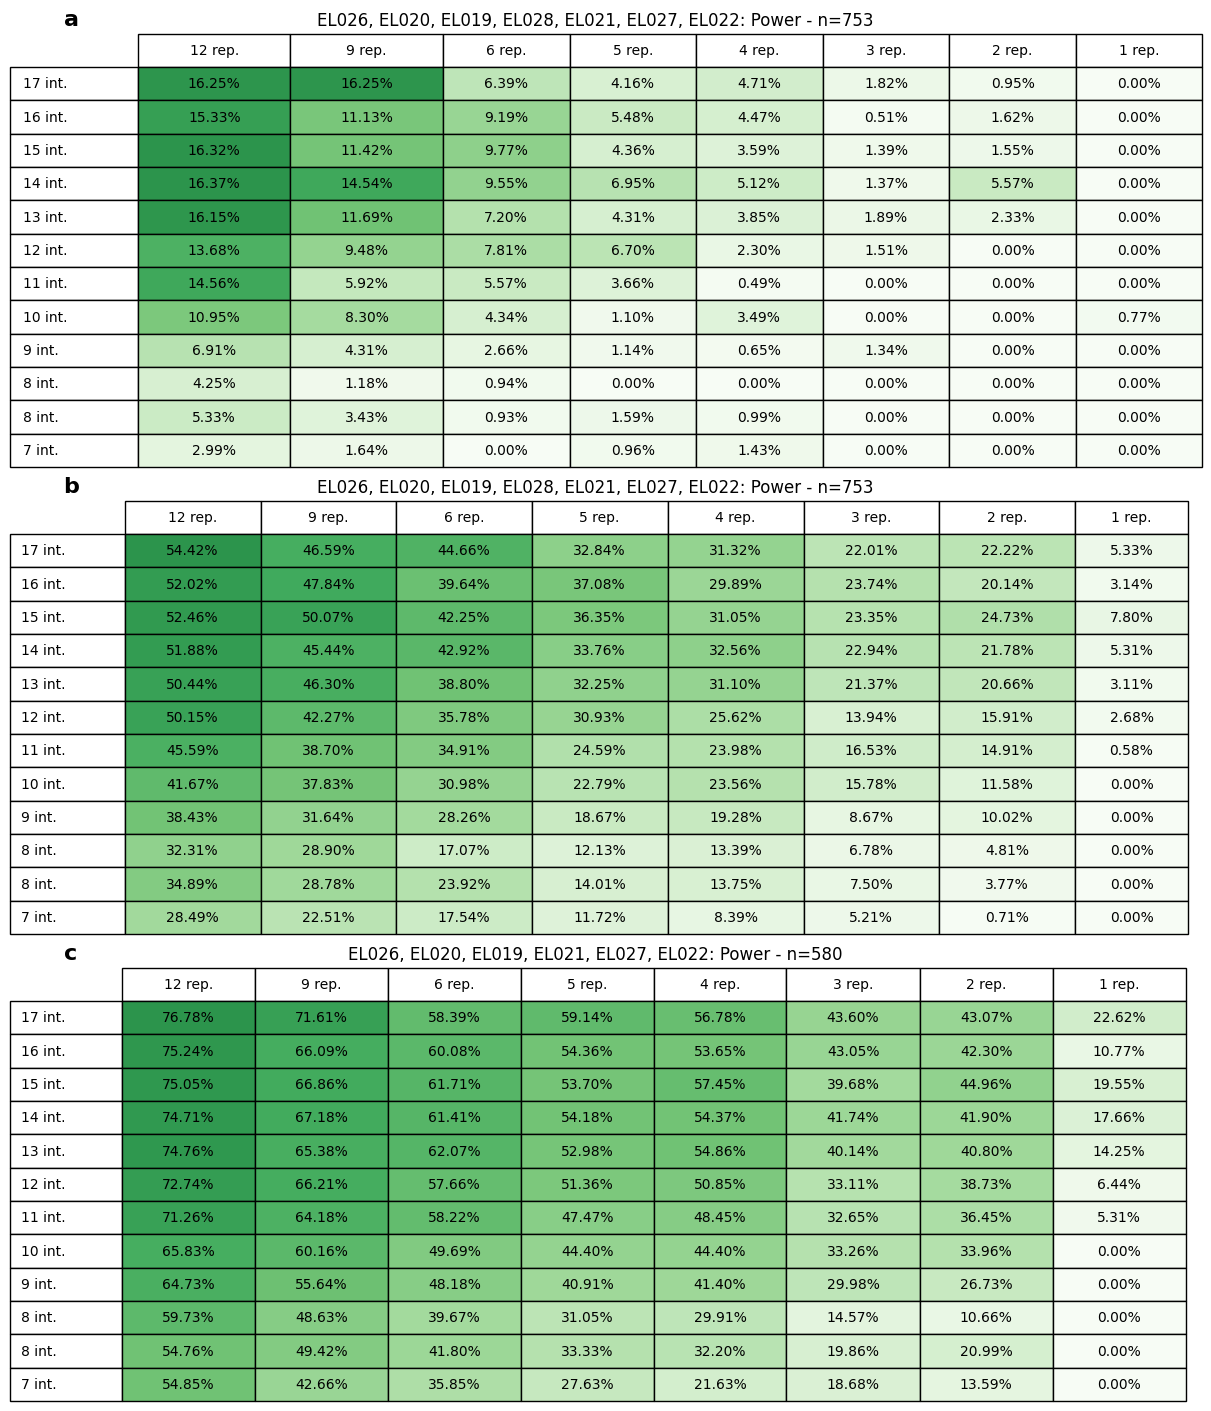

In [7]:
## grid with 2x2

from connectivity.analyze import evaluate_bootstrap_result, find_params_for_given_effect_size, fit_curve, normalize_ll_values, pick_random_replications, significant_exi_difference_testing
import matplotlib.colors as mcolors

from connectivity.load import parsed_list_to_numpy_array

def format_p(p):
    return "p < 0.01" if p < 0.01 else f"p = {p:.2f}"

np.random.seed(42)


def fdr_axis0_ignore_nan(pvals, method="bh"):
    """Apply FDR correction along axis=0, ignoring NaNs."""
    out = np.full_like(pvals, np.nan, dtype=float)  # placeholder
    
    # iterate over all indices except axis 0
    it = np.ndindex(pvals.shape[1:])
    for idx in it:
        sl = (slice(None),) + idx
        vec = pvals[sl]

        mask = ~np.isnan(vec)
        if mask.sum() > 0:
            out[sl][mask] = scipy.stats.false_discovery_control(vec[mask], method=method, axis=0)
    return out

def plot_table(ax, effect_size):
    rows_df = power_analysis_df[power_analysis_df["effect_size"] == effect_size]
    #rows_df = rows_df[rows_df["snr"] > 1.5]
    patient_ids =  rows_df["patient_id"].unique()
    complete_matrix = []
    for patient_id in patient_ids:
        pat_df = rows_df[rows_df["patient_id"] == patient_id]
        raw_matrix = []
        for df_i, row_df in pat_df.iterrows():
            if True: # row_df["snr"] > 1.5 and val is not None:
                # FIXME
                surr_p_values = parsed_list_to_numpy_array(row_df["surr_p_values"])
                # if True: # or surr_p_values[0, 0] < 0.05:
                #     if surr_p_values.shape[0] == len(EXCLUDE_INTENSITIES_MATRICES[17]):
                #         # fix problem for EL019
                #         pad = np.full((1, 8), np.nan)
                #         surr_p_values = np.vstack([pad, surr_p_values])
                
                raw_matrix.append(surr_p_values)
        raw_matrix = np.array(raw_matrix)

        raw_matrix = fdr_axis0_ignore_nan(pvals=raw_matrix, method="bh")
        nan_mask = np.isnan(raw_matrix)
        #raw_matrix = np.nan_to_num(raw_matrix, nan=1.0)
        # raw_matrix = scipy.stats.false_discovery_control(
        #     raw_matrix, method="bh", axis=0
        # )
        raw_matrix[nan_mask] = np.nan

        print(raw_matrix.shape)
        if raw_matrix.shape[1] == len(EXCLUDE_INTENSITIES_MATRICES[17]):
            print(patient_id)
            # fix problem for EL019
            pad = np.full((raw_matrix.shape[0], 1, raw_matrix.shape[2]), np.nan)

            # Concatenate along axis=1
            raw_matrix = np.concatenate([pad, raw_matrix], axis=1)
            print(raw_matrix.shape)

        complete_matrix.append(raw_matrix)

        # scipy.stats.false_discovery_control(
        #         spearman_p_values, method="bh"
        #     )
        

    complete_matrix = np.concatenate(complete_matrix)
    print(complete_matrix.shape)

    # this ensures that nan is ignored
    significance = np.where(np.isnan(complete_matrix), np.nan, complete_matrix < SIGNIFICANCE_LEVEL)
    power_matrix = np.nanmean(significance, axis=0)

    formatted_matrix = [
        [
            f"{value:.2%}"
            for j, value in enumerate(row)
        ]
        for i, row in enumerate(power_matrix)
    ]
    table = ax.table(
        cellText=formatted_matrix,  # Content
        colLabels= [
            f"{i_rep} rep."
            for i_rep in INCLUDE_REPLICATIONS_LIST
            ], # Row headers
        rowLabels = [
            f"{18-len(i)-1} int." for i in EXCLUDE_INTENSITIES_MATRICES[18]
        ],  # Column headers
        loc="center",
        cellLoc="center",
        bbox=[0, 0, 1, 1]  # [left, bottom, width, height] 
    )
    #table.scale(0.5, 0.5)
    #table.auto_set_font_size(False)
    #table.set_fontsize(6)  # Or lower
    cmap = plt.cm.Greens
    min_color_val = np.nanmin(power_matrix)
    max_color_val = np.nanmax(power_matrix) * 1.4
    # Apply colors based on value
    for i in range(power_matrix.shape[0]):
        for j in range(power_matrix.shape[1]):
            value = power_matrix[i, j]
            color = cmap((value-min_color_val)/(max_color_val-min_color_val))  # Get color from colormap
            table[i + 1, j].set_facecolor(
                color
            )  # +1 because row headers exist

    table.auto_set_column_width(
        col=list(range(len(EXCLUDE_INTENSITIES_MATRICES[18])))
    )

    ax.axis('off')
    ax.set_title(f"{', '.join(patient_ids)}: Power - n={len(rows_df)}")


fig = plt.figure(figsize=(12, 14), constrained_layout=True)
gs = GridSpec(
    3,
    1,
    figure=fig,
)

ax_1 = fig.add_subplot(gs[0, 0])
ax_1.set_title("a", loc="left", fontsize=16, fontweight="bold")
plot_table(ax=ax_1, effect_size=0.05)

ax_2 = fig.add_subplot(gs[1, 0])
ax_2.set_title("b", loc="left", fontsize=16, fontweight="bold")
plot_table(ax=ax_2, effect_size=0.1)

ax_3 = fig.add_subplot(gs[2, 0])
ax_3.set_title("c", loc="left", fontsize=16, fontweight="bold")
plot_table(ax=ax_3, effect_size=0.15)

plt.savefig("../output/figures/sfigure5.pdf", bbox_inches="tight", dpi=300)
plt.savefig("../output/figures/sfigure5.svg", bbox_inches="tight", dpi=300)
plt.show()